# Exercise 3

In [33]:
import torch
import torch.cuda
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import numpy as np

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cuda


In [35]:
def trainNetwork(network, optimizer, lossFunction, trainLoader, validLoader, epochs, device):
    network.train()
    for epoch in range(epochs):
        
        ### TRAINING ###
        trainLoss = 0
        correctTrain = 0
        totalTrain = 0
        for batch_nr, (images, labels) in enumerate(trainLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            # Predict
            predictions = network(images)

            # Get loss and backpropogate
            loss = lossFunction(predictions, labels)
            loss.backward() 

            # Optimize parameters (weights and biases) and remove gradients after
            optimizer.step() 
            optimizer.zero_grad()

            # Save loss for whole epoch
            trainLoss += loss.item()
            
            # Calculate training accuracy
            _, predictions = torch.max(predictions, 1) 
            correctTrain += (predictions == labels).sum().item() 
            totalTrain += len(images)

            #print(f'Epoch [{epoch+1}/{epochs}] Batch [{batch_nr}/{len(trainLoader)}]')
        

        trainLoss /= len(trainLoader)
        trainAccuracy = 100 * correctTrain / totalTrain

        ### VALIDATION ###
        validLoss = 0
        correctValid = 0
        totalValid = 0
        for batch_nr, (images, labels) in enumerate(validLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            # Predict
            predictions = network(images)

            # Get loss
            loss = lossFunction(predictions, labels)

            # Save loss for whole epoch
            validLoss += loss.item()

            # Calculate vaildation accuracy
            _, predictions = torch.max(predictions, 1) 
            correctValid += (predictions == labels).sum().item() 
            totalValid += len(images)

            #print(f'Epoch [{epoch+1}/{epochs}] Batch [{batch_nr}/{len(validLoader)}]')

        validLoss /= len(validLoader)
        validAccuracy = 100 * correctValid / totalValid

        # Print reuslt of epoch
        print(f'Epoch [{epoch+1}/{epochs}] \t Training Loss: {trainLoss} \t Validation Loss: {validLoss} \t Traning Acc: {trainAccuracy}% \t Validation Acc: {validAccuracy}%')

In [46]:
def extractFeatures(network, loader, device):
    network.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_ in loader:
            images, labels_ = images.to(device), labels_.to(device)  
            output = network(images)
            features.append(output.cpu().numpy())
            labels.append(labels_.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features, labels

In [37]:
# Load and normalizde the MNIST data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

batchSize = 500
validSplit = 0.20 # use 20% of train set as validation

trainValidSet = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testSet = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

validSize = int(np.ceil(len(trainValidSet)*validSplit))
trainSize = int(np.floor(len(trainValidSet)*(1-validSplit)))

trainSet, validSet = torch.utils.data.random_split(trainValidSet, [trainSize, validSize])
testSubset = torch.utils.data.Subset(testSet, range(2000))

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSubset, batch_size=batchSize, shuffle=False)


In [38]:
# Define the network class
class ConvNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 4 * 4, 250)
        self.fc2 = nn.Linear(250, 10)
        self.activation = activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [39]:
class FeatureExtNet(nn.Module):
    def __init__(self, conv_net):
        super().__init__()
        self.conv1 = conv_net.conv1
        self.pool = conv_net.pool
        self.conv2 = conv_net.conv2
        self.activation = conv_net.activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

In [40]:
learningRate = 1e-6
epochs = 1
network = ConvNet(F.leaky_relu).to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=learningRate)
lossFunction = nn.CrossEntropyLoss().to(device)
trainNetwork(network, optimizer, lossFunction, trainLoader, validLoader, epochs, device)

Epoch [1/1] 	 Training Loss: 2.305245158572992 	 Validation Loss: 2.3048567374547324 	 Traning Acc: 8.4875% 	 Validation Acc: 8.608333333333333%


In [47]:
featureNet = FeatureExtNet(network).to(device)
features, labels = extractFeatures(featureNet, testLoader, device)
labels = np.array(labels).flatten()
pca = PCA(n_components=2)
pcaFeatures = pca.fit_transform(features)
tSne = TSNE(n_components=2)
tSneFeatures = tSne.fit_transform(features)

In [48]:
def plot(features, labels):
    colorList = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'pink', 'brown', 'black', 'cyan']
    colors = [colorList[label] for label in labels]

    plt.scatter(features[:,0], features[:,1], c=colors, linewidths=0.01)
    plt.show()

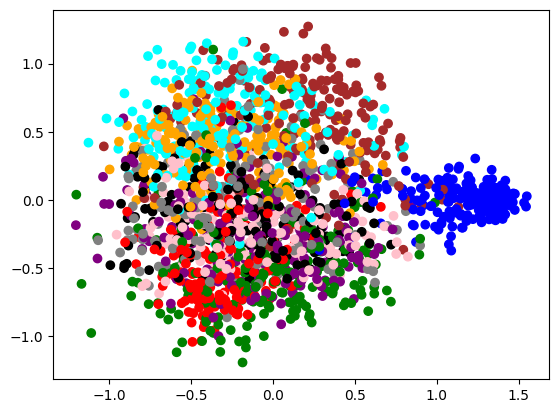

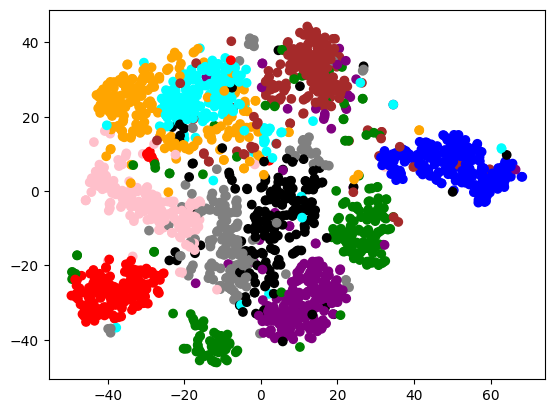

In [49]:
plot(pcaFeatures, labels)
plot(tSneFeatures, labels)

In [50]:
# plt.scatter(pcaFeatures[:,0], pcaFeatures[:,1], c=labels)
# plt.colorbar()
# plt.show()

In [52]:
learningRate2 = 1e-3
epochs2 = 20
network2 = ConvNet(F.leaky_relu).to(device)

optimizer2 = torch.optim.SGD(network2.parameters(), lr=learningRate2)
lossFunction2 = nn.CrossEntropyLoss().to(device)
trainNetwork(network2, optimizer2, lossFunction2, trainLoader, validLoader, epochs2, device)

Epoch [1/20] 	 Training Loss: 2.294388780991236 	 Validation Loss: 2.2903068562348685 	 Traning Acc: 9.85625% 	 Validation Acc: 10.15%
Epoch [2/20] 	 Training Loss: 2.2883293703198433 	 Validation Loss: 2.2844617068767548 	 Traning Acc: 9.85625% 	 Validation Acc: 10.15%
Epoch [3/20] 	 Training Loss: 2.282288335263729 	 Validation Loss: 2.2785407304763794 	 Traning Acc: 9.85625% 	 Validation Acc: 10.15%
Epoch [4/20] 	 Training Loss: 2.2762298087279 	 Validation Loss: 2.272572269042333 	 Traning Acc: 10.310416666666667% 	 Validation Acc: 11.875%
Epoch [5/20] 	 Training Loss: 2.2700658266743026 	 Validation Loss: 2.2663876712322235 	 Traning Acc: 14.345833333333333% 	 Validation Acc: 17.608333333333334%
Epoch [6/20] 	 Training Loss: 2.2636552651723227 	 Validation Loss: 2.25990159312884 	 Traning Acc: 18.929166666666667% 	 Validation Acc: 20.675%
Epoch [7/20] 	 Training Loss: 2.2568811401724815 	 Validation Loss: 2.252966493368149 	 Traning Acc: 20.802083333333332% 	 Validation Acc: 22.35

In [53]:
featureNet2 = FeatureExtNet(network2).to(device)
features2, labels2 = extractFeatures(featureNet2, testLoader, device)
labels2 = np.array(labels2).flatten()
pca2 = PCA(n_components=2)
pcaFeatures2 = pca2.fit_transform(features2)
tSne2 = TSNE(n_components=2)
tSneFeatures2 = tSne2.fit_transform(features2)

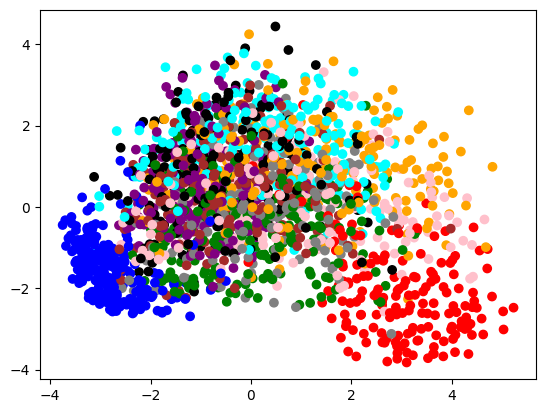

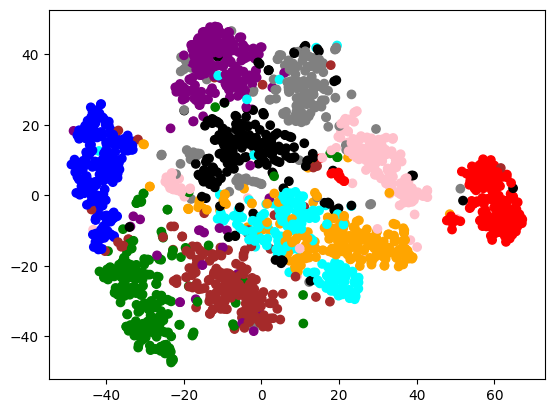

In [54]:
plot(pcaFeatures2, labels2)
plot(tSneFeatures2, labels2)

IndexError: ignored

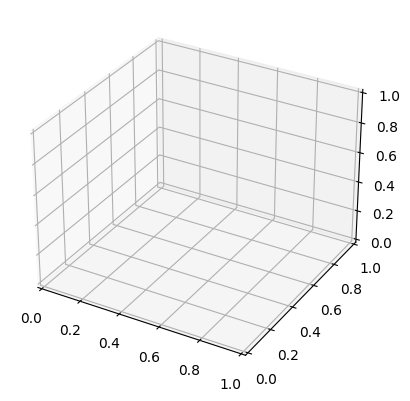

In [56]:
pca3d = PCA(n_components=3)
pcaFeatures3d = pca3d.fit_transform(features2)
tSne3d = TSNE(n_components=3)
tSneFeatures3d = tSne3d.fit_transform(features2)

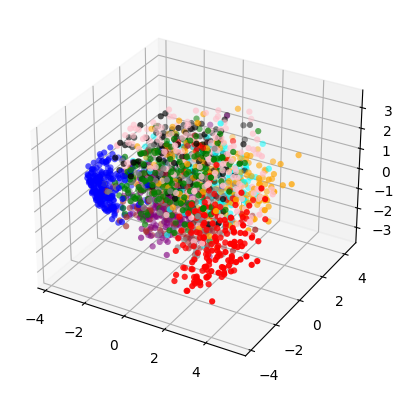

In [58]:
colorList = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'pink', 'brown', 'black', 'cyan']
colors = [colorList[label] for label in labels]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(pcaFeatures3d[:,0], pcaFeatures3d[:,1], pcaFeatures3d[:,2], c=colors, linewidths=0.01)
plt.show()